## Read the feature selected  data frame via mutual information

In [9]:
import pandas as pd
import numpy as np
import time

np.random.seed(33)
df = pd.read_csv("./data/featureSelectedAllDataWithY.csv")
# df = pd.read_csv("../data/Cleaned_dat_encoded.csv")
print(df.shape)
df.head()

(534730, 21)


,esi,age,ethnicity,race,lang,maritalstatus,employstatus,insurance_status,arrivalmode,previousdispo,...,meds_analgesics,meds_antiplateletdrugs,meds_cardiacdrugs,meds_cardiovascular,meds_diuretics,meds_elect/caloric/h2o,meds_gastrointestinal,meds_psychotherapeuticdrugs,meds_vitamins,disposition
0,4,40,1,8,1,8,2,4,6,7,...,0,0,0,0,0,0,0,0,0,2
1,4,66,1,4,1,5,3,1,2,7,...,0,0,0,0,0,0,0,0,0,2
2,2,66,1,4,1,5,3,1,6,3,...,0,0,0,0,0,0,0,0,0,2
3,2,66,1,4,1,5,3,1,2,3,...,0,0,0,0,0,0,0,0,0,2
4,3,84,1,5,2,10,6,3,6,3,...,0,0,0,2,1,2,2,0,1,1


## Read the feature selected columns for training

## Grid search for Random forest

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25,shuffle=True)

y_train = training_data['disposition']
y_test = testing_data['disposition']
X_train = StandardScaler().fit_transform(training_data.drop("disposition",axis = 1))
X_test = StandardScaler().fit_transform(testing_data.drop("disposition",axis = 1))

# y_train = np.array(y_train)[:100]
# y_test = np.array(y_test)[:10]
# X_train = np.array(X_train)[:100,]
# X_test = np.array(X_test)[:10,]

clf = GridSearchCV(RandomForestClassifier(random_state=0,class_weight="balanced"), param_grid = param_grid, cv = 5, n_jobs=12,verbose=False)
best_clf = clf.fit(X_train, y_train)

print("Best cross validation accuracy: {:.2f}".format(best_clf.best_score_))
print("Test set score: {:.2f}".format(best_clf.score(X_test,y_test)))
print("Best parameters: {}".format(best_clf.best_params_))

Best cross validation accuracy: 0.83
Test set score: 0.83
Best parameters: {'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}


In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
bootstrap=best_clf.best_params_['bootstrap']
max_depth=best_clf.best_params_['max_depth']
max_features=best_clf.best_params_['max_features']
min_samples_leaf=best_clf.best_params_['min_samples_leaf']
min_samples_split=best_clf.best_params_['min_samples_split']
n_estimators = best_clf.best_params_['n_estimators']

clf = RandomForestClassifier(random_state=0,class_weight="balanced",bootstrap=bootstrap,max_depth=max_depth,
                            max_features=max_features,min_samples_leaf=min_samples_leaf,
                            min_samples_split=min_samples_split,
                            n_estimators=n_estimators).fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
print(cm)
print(ac)

[[25343  7492]
 [10281 63830]]
0.8338133263516168


## Statistic measurement of the model

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score
from prettytable import PrettyTable
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
MCCs = []
auROCs = []
auPRCs = []

accuracy_scores.append(accuracy_score(y_true=y_test, y_pred=y_pred))
f1_scores.append(f1_score(y_true=y_test, y_pred=y_pred))
recall_scores.append(recall_score(y_true=y_test, y_pred=y_pred))
precision_scores.append(precision_score(y_true=y_test, y_pred=y_pred))
MCCs.append(matthews_corrcoef(y_true=y_test, y_pred=y_pred))
auROCs.append(roc_auc_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 1]))
auPRCs.append(average_precision_score(y_true=y_test,  y_score=clf.predict_proba(X_test)[:, 0]))

table = PrettyTable()
column_names = ['Accuracy', 'auROC', 'auPRC', 'recall', 'precision', 'f1', 'MCC']
table.add_column(column_names[0], np.round(accuracy_scores, 4))
table.add_column(column_names[1], np.round(auROCs, 4))
table.add_column(column_names[2], np.round(auPRCs, 4))
table.add_column(column_names[3], np.round(recall_scores, 4))
table.add_column(column_names[4], np.round(precision_scores, 4))
table.add_column(column_names[5], np.round(f1_scores, 4))
table.add_column(column_names[6], np.round(MCCs, 4))


print(table)

+----------+--------+--------+--------+-----------+--------+--------+
| Accuracy | auROC  | auPRC  | recall | precision |   f1   |  MCC   |
+----------+--------+--------+--------+-----------+--------+--------+
|  0.8338  | 0.9035 | 0.8342 | 0.7718 |   0.7114  | 0.7404 | 0.6196 |
+----------+--------+--------+--------+-----------+--------+--------+


# Results visualization

## Confusion matrix

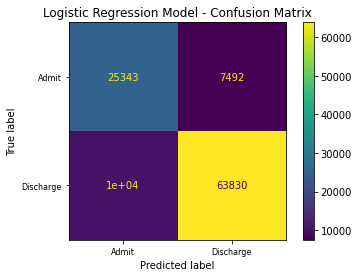

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(clf,X_test,y_test)
plt.title("Logistic Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Admit", "Discharge"], fontsize=8)
plt.yticks(range(2), ["Admit", "Discharge"], fontsize=8)
plt.show()

## Precision Recall curve

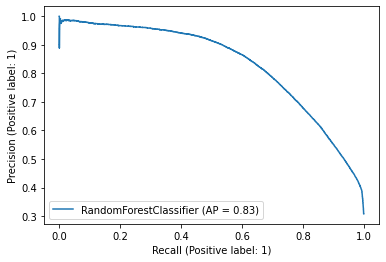

In [15]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
plot_precision_recall_curve(clf,X_test,y_test,pos_label=1)

## ROC curve

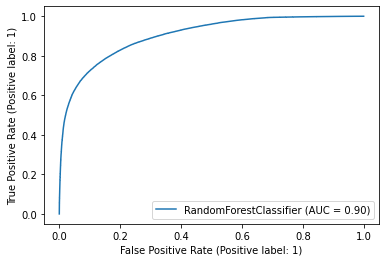

In [16]:
plot_roc_curve(clf,X_test,y_test,pos_label=1)

## Quantative matrix

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score

print(classification_report(y_test, y_pred, target_names=["Admit", "Discharge"]))
print("Balanced Accuracy:" + format(balanced_accuracy_score(y_test,y_pred),'.2f'))
print("Matthews Corr Coef:" + format(matthews_corrcoef(y_test,y_pred),'.2f'))

              precision    recall  f1-score   support

       Admit       0.71      0.77      0.74     32835
   Discharge       0.89      0.86      0.88     74111

    accuracy                           0.83    106946
   macro avg       0.80      0.82      0.81    106946
weighted avg       0.84      0.83      0.84    106946

Balanced Accuracy:0.82
Matthews Corr Coef:0.62
